In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 目标
- 学习直方图均衡化的概念，然后用该技术改善图像的对比度

# 1. 理论
若一幅图像的像素值聚集于某一个范围之内，例如一幅明亮的图像所有的像素都有较高的亮度值。但是一幅好的图像，像素值应该分布在整个像素值区间中，如0-255。如下图所示，需要拉伸直方图的两个端点，这就是直方图均衡化的目的。通常该操作可以改善图像的对比度。![](./imgs/histogram_equalization.png)

更多的直方图均衡化的细节可以阅读[Wikipedia](http://en.wikipedia.org/wiki/Histogram_equalization)，该文档解释了直方图拉伸的原理和示例。下面首先用Numpy来实现，在后面的例子中再使用OpenCV的函数。

对图像进行该操作：![](../data/wiki.jpg)

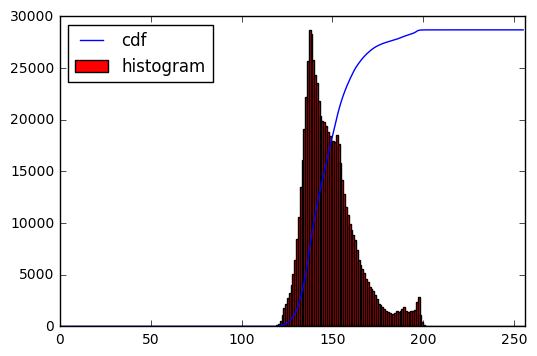

In [23]:
img = cv2.imread('../data/wiki.jpg', cv2.IMREAD_GRAYSCALE)

hist, bins = np.histogram(img.flatten(), 256, [0, 256])

cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

plt.plot(cdf_normalized, color='b')
_ = plt.hist(img.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.legend(('cdf', 'histogram'), loc='upper left')

可以看到直方图集中于较亮的区域，接下来要把直方图拉伸到整个频谱上。因此需要一个变换函数，该函数将输入像素的值拉伸到整个亮度区域（0-255）。这就是直方图均衡化所做的工作。

首先找到直方图中除0之外的最小值，然后应用wiki页面中方法。下面的代码中使用了numpy中掩码数组的概念。对于掩码数组来说，所有的操作都在非掩码的元素上执行。可以阅读Numpy的掩码数组文档获得更多细节。

In [24]:
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8')
cdf

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   2,   3,   4,   5,   7,   9,
        13,  16,  21,  27,  34,  42,  52,  62,  72,  82,  91,  99, 107,
       115, 122, 129, 136, 143, 150, 156, 163, 169, 176, 183, 188, 194,
       198, 202, 206, 210, 213, 217, 220, 222, 225, 227, 229, 231, 232,
       234, 235, 237, 238, 239, 240, 241, 242, 242, 243, 243, 24

现在得到了每一个输入像素值对应的输出像素的值。然后应用变换：

In [25]:
img2 = cdf[img]

计算新图像的直方图：

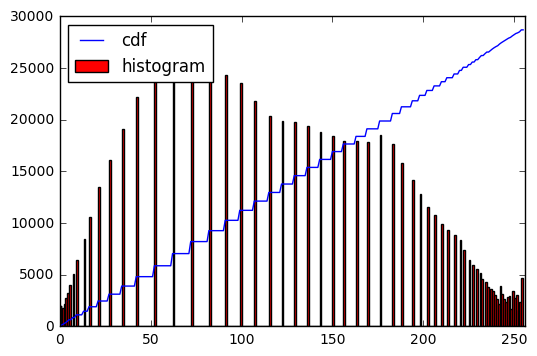

In [31]:
hist, bins = np.histogram(img2.flatten(), 256, [0, 256])

cdf2 = hist.cumsum()
cdf_normalized2 = cdf2 * hist.max() / cdf2.max()

plt.plot(cdf_normalized2, color='b')
_ = plt.hist(img2.flatten(), 256, [0, 256], color='r')
plt.xlim([0, 256])
plt.legend(('cdf', 'histogram'), loc='upper left')

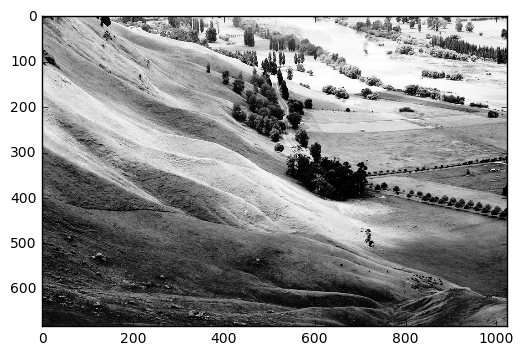

In [34]:
plt.imshow(img2, 'gray')

直方图均衡化的另外一个重要的特性是：即使图像非常暗，也能得到近似的结果。因为该操作可以将图像调整至相同的亮度条件。这在很多情况下都很有用，例如在人脸识别中，在训练人脸数据之前首先用直方图均衡化将它们的亮度条件调整一致。

# 2. 利用OpenCV进行直方图均衡化
OpenCV中提供了**cv2.equalizeHist()**来实现直方图均衡化，它输入一幅灰度图像，输出为直方图均衡化之后的图像。

下面的代码使用了与之前相同的图像：

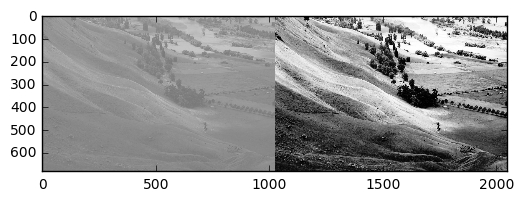

In [35]:
img = cv2.imread('../data/wiki.jpg', cv2.IMREAD_GRAYSCALE)
equ = cv2.equalizeHist(img)
res = np.hstack((img, equ))
plt.imshow(res, 'gray')

可以用不同光照条件的不同图像进行均衡化，来查看结果。

直方图均衡化对于图像中像素值集中于有限区域的情况非常有效。但对于像素分布覆盖了很大亮度区域且直方图方差很大的情况（既有非常亮的像素，也有非常暗的像素），直方图均衡化效果不够好。请查看更多资源中关于SOF的链接。

# 3. CLAHE（Contrast Limited Adaptive Histogram Equalization）
在前面的算法中，关注的是图像的全局对比度。在很多情况，这不是一个好的方法。例如下面的图像显示了输入图像和直方图均衡化后的结果：![](./imgs/clahe_1.jpg)
背景的对比度确实得到了改善，但是通过对比两幅图像中雕像面部，直方图均衡化后由于过亮损失了大量信息。这是因为像素的亮度值并没有集中在一个特定区域。

为了解决这一问题，需要使用**自适应直方图均衡化**。在这种技术中，图像被分为小块（在OpenCV中每个小块的大小默认为8x8）。然后每个小块进行直方图均衡化。因此在一个小的区域，直方图被限制在一个小的范围（除非存在噪声）。如果存在噪声，噪声将被放大。为了避免噪声的影响，需要应用**对比度限制**。如果任何一个直方图的bins大于指定的对比度限制（OpenCV中默认为40），这些像素值将被截断，在进行直方图均值化之前，均匀分布到其他bins中。均衡化后移除人工生成的边界，用双线性插值计算边界的值。

下面的代码展示了在OpenCV中，如何使用CLAHE：

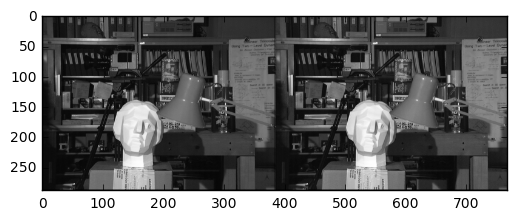

In [41]:
img = cv2.imread('../data/tsukuba.png', cv2.IMREAD_GRAYSCALE)

clahe = cv2.createCLAHE(clipLimit=0.2, tileGridSize=(8, 8))
cl1 = clahe.apply(img)

res = np.hstack((img, cl1))

plt.imshow(res, 'gray')

# 4. 额外资源
1. 维基百科：[直方图均衡化](http://en.wikipedia.org/wiki/Histogram_equalization)
2. [Numpy掩码数组](http://docs.scipy.org/doc/numpy/reference/maskedarray.html)
3. 如何在OpenCV中调整对比度：[stackoverflow](http://stackoverflow.com/questions/10549245/how-can-i-adjust-contrast-in-opencv-in-c)
4. 如何用OpenCV均衡对比度与亮度：[stackoverflow](http://stackoverflow.com/questions/10561222/how-do-i-equalize-contrast-brightness-of-images-using-opencv)